# **Détection de la pneumonie - Application du Transfer Learning**

Dans ce notebook, nous nous attacherons à entraîner un modèle capable de détecter la pneumonie à partir d'images scanner. Pour ce faire nous utiliserons le dataset **[Chest XRay Pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)** pour affiner un modèle Keras préentrainé. Nous suivrons ces étapes :  

### **1. Compréhension du problème**  

La 1ère étape est de comprendre notre problématique. Cela nous permettra d'en tirer certaines conclusions, telles que le choix de la métrique à laquelle nous accorderons le plus d'importance, ou la façon de résoudre les autres questions qui arriveront lors de la mise en oeuvre.  

### **2. Analyse du dataset**  

Nous devrons observer le dataset pour déterminer comment en standardiser le contenu afin de le rendre exploitable par le modèle.
Nous devrons également prêter attention à la répartition des classes dans le dataset, afin de rééquilibrer l'entraînement si nécessaire.  

### **3. Preprocessing du dataset**

Nous adapterons notre dataset au format attendu par le modèle.

### **4. Création du modèle**

Le modèle sera créé par une fonction selon les paramètres définis dans settings.

### **5. Entraînement du modèle**

Nous entrainerons le modèle sur notre dataset d'entraînement, et surveillerons ses résultats à chaque epoch pour vérifier qu'il évolue dans le bon sens et ne se surentraîne pas.

### **6. Mise en place d'un suivi des tests**  

Grâce à MLFlow, nous enregistrerons les résultats de nos tests au fur et à mesure (paramètres et résultats) afin de facilement comparer nos modèles/paramètres d'entraïnement. Cela nous permetre de passer à l'étape suivante :  

### **7. Choix du modèle**  

Après avoir testé différents modèles préentrainés potentiellement intéressants, nous les comparerons grâce aux métriques enregistrés dans MLFlow afin de choisir notre modèle de travail final.  

### **8. Affiner notre modèle**  

Une fois notre modèle final sélectioné, nous jouerons avec ses paramètres afin de chercher les meilleures performances possibles pour le cas étudié.  

### **9. Résultats finaux**  

Nous présenterons les résultats finaux de notre modèle et le mettrons à disposition pour démonstration.

## **0.a Importation des dépendances et des credentials de MLFlow**

In [1]:
import os
import shutil
import json

import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from functions.data.prepare_data import prepare_data
from functions.show_predictions import show_predictions
from functions.data.get_train_test import get_train_test
from functions.initialize_model import initialize_model
from functions.mlflow.get_run_name import get_run_name
from settings import params, model_name, folders, added_layers, experiment_name, testing_cycle
from functions.mlflow.show_parameters import show_parameters
from functions.data.dataset_analysis import dataset_analysis
from functions.mlflow.show_metrics import show_metrics
from functions.mlflow.show_matrix import show_matrix

2025-05-28 19:23:06.153528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 19:23:06.374866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748452986.470015    6315 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748452986.495705    6315 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748452986.684483    6315 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## **0.b Chargement du dataset**

Si le dataset n'est pas déjà présent localement, on le récupère automatiquement dans sa dernière version.

In [2]:
# Download latest version of dataset and store it locally
if not os.path.exists("data"):
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

    target_dir = "data"
    os.makedirs(target_dir, exist_ok=True)
    shutil.move(path, target_dir)
    removable_folder_paths = ("data/chest_xray/", "data/2/chest_xray/chest_xray", "data/2/chest_xray/__MACOSX")
    for folder_path in removable_folder_paths:
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            shutil.rmtree(folder_path)

## **1. Compréhension du problème**

Nous sommes ici dans le cadre d'un **modèle à application médicale**. Nous devons donc être très attentifs à ce que nous faisons. Plusieurs possibilités différentes peuvent influencer nos choix, selon l'usage de ce modèle :

- S'agit-il d'un modèle destiné à détecter la possibilité d'une pneumonie **en amont de l'examen d'un professionnel de santé ?** Dans ce cas, nous voulons privilégier le recall, qui minimise les chances de passer à côté d'une pathologie, quitte a parfois donner de faux positifs.

- A l'inverse, s'il s'agit d'un modèle destiné à **valider le diagnostic positif d'un médecin**, on privilégiera alors la précision, puisqu'il s'agira de détecter la maladie à coup sûr et d'éviter les faux positifs.

Un modèle plus généraliste pourrait privilégier l'accuracy, mais nous allons ici partir du principe que le modèle est destiné à détecter la maladie **en amont** et déclencher l'appel à l'expertise d'un médecin dès que le moindre doute est soulevé. Nous privilégieront donc le recall, et en valeur secondaire la précision. On veut **un minimum de cas non détectés** et une **qualité de diagnostic positif maximale**, car notre modèle a besoin d'être fiable, de ne rater aucun cas mais également d'être **digne de confiance** (si on détecte 100% des cas mais que la moitié des détections sont des faux positifs, l'outil n'a aucune utilité).

## **2. Analyse du dataset**

Nous analysons le contenu du dataset, en particulier le format des images et la répartition des classes. Nous utiliserons la fonction **dataset_analysis** définie dans **functions/dataset_analysis.py**

Nombre d'images en erreur : 0
Aperçu des différents formats d'image


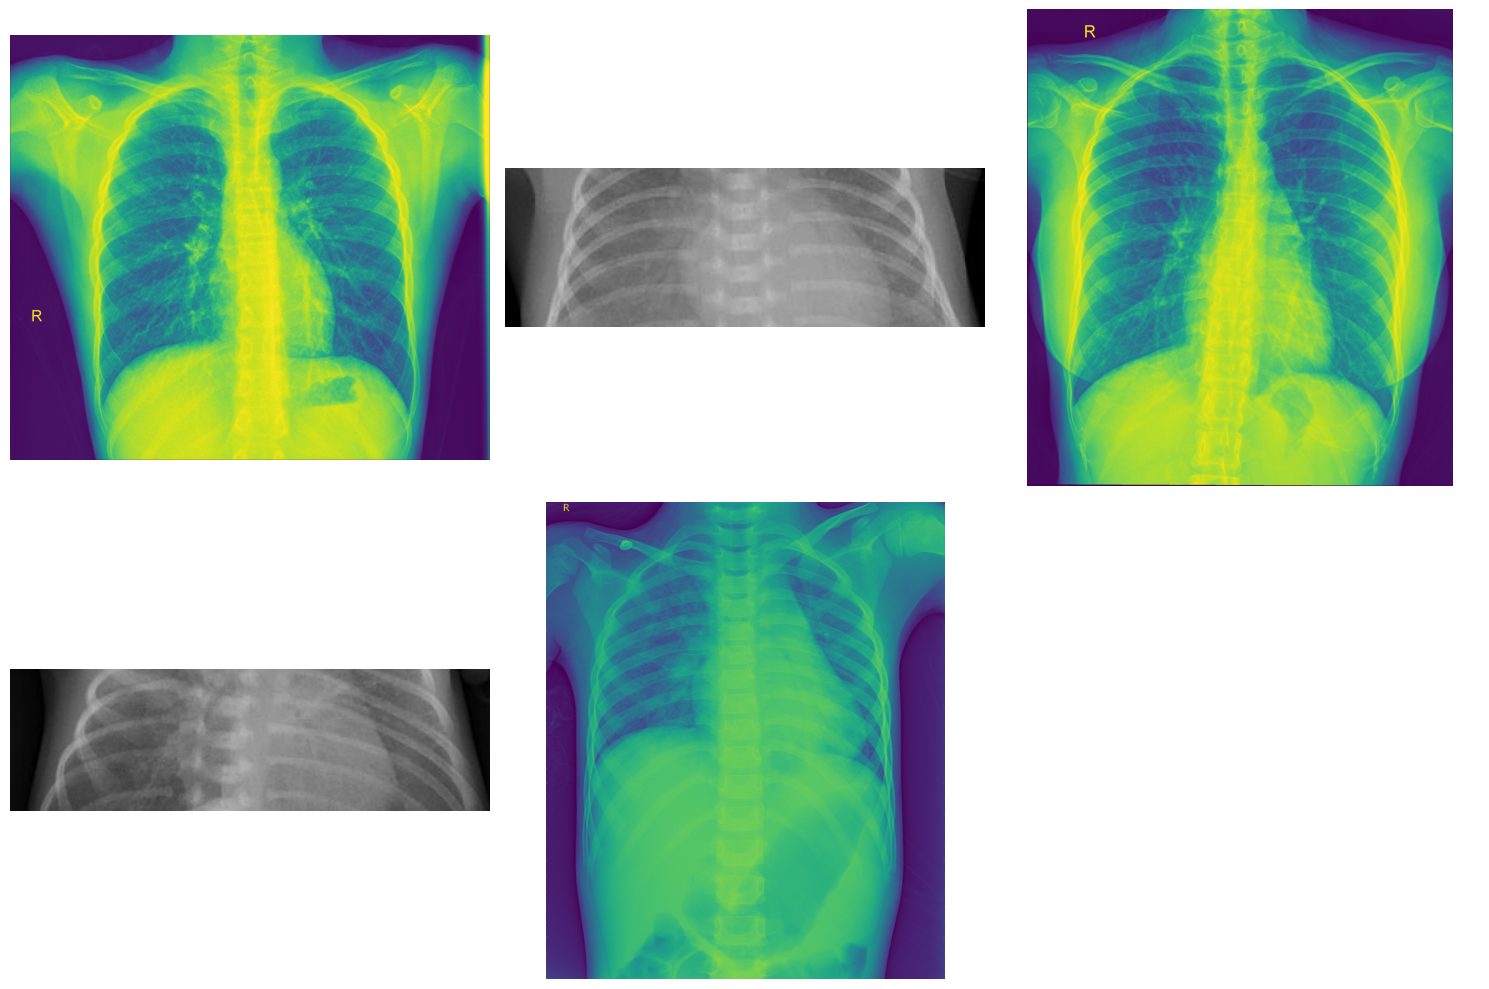

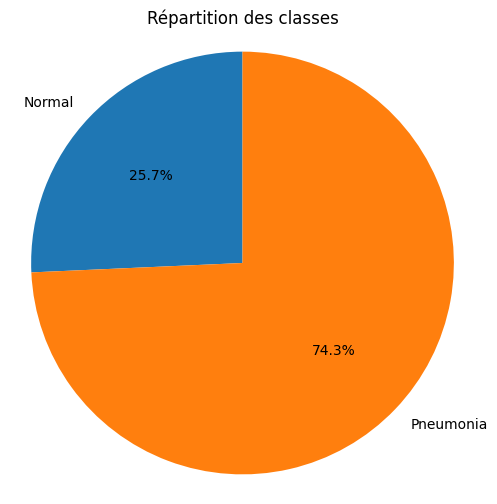

In [3]:
dataset_analysis()

On peut voir que les images du dataset peuvent prendre **différents ratio width/height**. Certaines sont en couleur, d'autres non mais cela ne devrait pas poser de souci car elles sont toujours monochrome. Une étude en niveaux de gris serait peut être préférable. Comme les modèles préentrainés attendent du rgb, on peut essayer de les tromper en triplant la valeur d'intensité du greyscale pour le faire passer pour du rgb. Cette approche devra être testée pour en définir l'efficacité. Le dataset ne contient pas d'images erronées. J'observe que les classes sont déséquilibrées avec **seulement un quart des images concernant des poumons sains**, il faudra en tenir compte lors de l'entraînement et trouver des méthodes pour mitiger cela.

## **3. Preprocessing du dataset**

Selon les caractéristiques définies dans **settings > params["img_size"]** et **params["rgb"]**, nous allons transformer les images du dataset pour qu'elles correspondent à ces valeurs après avoir vérifié qu'elles n'y correspondent pas déjà (grâce à un fichier json **data_config**) et les enregistrer dans le dossier **data/processed**. Nous utiliserons pour cela la fonction **prepare_data** définie dans **functions/img_treatment**. Cette fonction ajoutera des bandes noires sur les côtés de l'image pour obtenir le ratio 1:1 désiré sans en altérer le contenu, la redimensionnera et la convertira en faux rgb (intensité du pxiel dupliqué sur trois channels) si nécessaire.

In [4]:
config_path = os.path.join("data/processed", "data_config.json")

current_config = {
    "rgb": params["rgb"],
    "img_size": params["img_size"]
}

if os.path.exists(config_path):
    with open(config_path, "r") as f:
        previous_config = json.load(f)
    if previous_config != current_config:
        for folder in folders:
            prepare_data(folders[folder]["input"], folders[folder]["output"])
else:
    for folder in folders:
            prepare_data(folders[folder]["input"], folders[folder]["output"])

with open(config_path, "w") as f:
        json.dump(current_config, f)

Nous stockons ensuite les datasets d'entraînement, de test et de validation via la fonction **get_train_test** définie dans **functions/data**. 

Selon la valeur de settings > params["equilibrate"], nous **rééquilibrerons les poids des classes** pour tenter de limiter l'influence du déséquilibre entre les classes lors de l'entraînement.

In [5]:
# Préparation des données de travail
X_train, y_train = get_train_test(folders["train"]["output"])
X_test, y_test = get_train_test(folders["test"]["output"])
X_val, y_val = get_train_test(folders["val"]["output"])

# Rééquilibrage du dataset
class_weight_dict = {0: 1.0, 1: 1.0}
if params["equilibrate"]:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))

On affiche un petit echantillonnage de nos dataset pour vérifier que tout est ok.

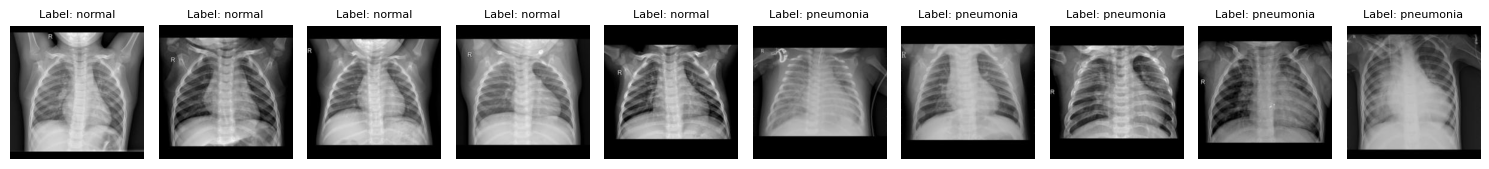

In [6]:
# Echantillonnage pour vérification
# Sélectionner les indices des labels
indices_label_0 = [i for i, y in enumerate(y_train) if y == 0][:5]
indices_label_1 = [i for i, y in enumerate(y_train) if y == 1][:5]

# Fusionner les indices sélectionnés
selected_indices = indices_label_0 + indices_label_1

# Affichage
plt.figure(figsize=(15, 3))
for idx, i in enumerate(selected_indices):
    plt.subplot(1, 10, idx + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {"normal" if y_train[i] == 0 else "pneumonia"}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

Nous transformons les images pour les rendre exploitables par les modèles (normalisation des valeurs de pixels, format des réponses attendues..) 
 
Selon la valeur de settings > params["data_augmentation"], nous **appliquerons des modifications aléatoires** (rotations, retournements, zoom..) aux images minoritaires pendant l'entrainement pour en aumenter artificellement la diversité.

In [ ]:
# Preprocessing
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

#Transform y_train, y_test to the shape expected by the model
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

if params["data_augmentation"]:
    datagen = ImageDataGenerator(
        rotation_range=10,
        horizontal_flip=True,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )

    datagen.fit(X_train)

## **4. Création du modèle**

Nous créons le modèle grâce à une fonction **initialize_model** qui prend en compte les paramètres définis dans **settings > params** et les couches supplémentaires définies dans **settings > added_layers**. Celà nous permet de **facilement tester de nombreux paramètres/modèles différents sans devoir toucher au code**, et de **tout logger facilement dans MLFlow** par la suite pour comparaison ultérieure.

In [ ]:
# Création du modèle
model = initialize_model()
model.summary()

## **5. Entraînement du modèle**

Nous entrainons le modèle sur notre dataset d'entraînement, et surveillerons ses résultats à chaque epoch pour vérifier qu'il évolue dans le bon sens et ne se surentraîne pas.

Pour ce cas précis nous surveillons son évolution à partir du dataset de test, car les métriques fournies par le dataset d'évaluation sont trop éloignées des résultats finaux et ne nous offrent pas un bon indicateur de l'évolution de la performance du modèle. En général il aurait fallu ici utiliser le dataset de validation, plus léger pour accélérer l'entraînement.

Si **settings > params["data_augmentation"] == True**, on utilise ici les techniques de rotation, zoom,.. définies précédemment.

In [ ]:
# Entrainement du modèle
if params["data_augmentation"]:
    model_info = model.fit(
        datagen.flow(X_train, y_train, batch_size=params["batch_size"]),
        epochs=params["epochs"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )
else:
    model_info = model.fit(
        X_train, y_train,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        validation_data=(X_test, y_test),
        class_weight=class_weight_dict
    )

## **6. Mise en place d'un suivi des tests**  

Nous affichons la matrice de confusion de notre modèle, et l'enregistrons en tant qu'image pour pouvoir la logger plus tard.

In [ ]:
# Matrice de confusion
y_test_classes = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

labels = ["Normal", "Pneumonia"]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)

fig, ax = plt.subplots(figsize=(6,4))
disp.plot(cmap='GnBu', ax=ax) 
plt.title("Confusion matrix")
img_path = "confusion_matrix.png"
plt.savefig(img_path)
plt.show()
plt.close()

Grâce à MLFlow, nous enregistrons les résultats de nos tests (paramètres et résultats) afin de **facilement comparer nos modèles/paramètres d'entraïnement**.

Nous loggons :
- Le lien du dataset
- Les paramètres
- Les métriques finaux
- Les métriques de suivi durant l'entraînement
- La matrice de confusion (sous forme d'artifact)
- Le modèle
- Les poids du modèle

In [ ]:
# Log results into MLFlow
results = model.evaluate(X_test, y_test, return_dict=True)
mlflow.set_tracking_uri("http://localhost:5000")
experiment = mlflow.set_experiment(experiment_name=experiment_name)
run_name = get_run_name(experiment, params["model"])

weights_path = "model.weights.h5"
model.save_weights(weights_path)

with mlflow.start_run(run_name=run_name) as run:
    run_id = run.info.run_id

    # Log dataset
    mlflow.log_param("dataset_url", "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    mlflow.set_tag("dataset", "chest-xray-pneumonia")
    mlflow.set_tag("testing_cycle", testing_cycle)

    # Log parameters
    mlflow.log_params(params)
    for i, added_layer in enumerate(added_layers):
        mlflow.log_params({
            f"added_layer_{i}": added_layer
        })
    # Log training metrics
    for epoch in range(len(model_info.history['loss'])):
        for metric_name, values in model_info.history.items():
            mlflow.log_metric(f"training {metric_name}", values[epoch], step=epoch)
    # Log final metrics
    mlflow.log_metrics(
        results
    )
    # Log confusion matrix
    mlflow.log_artifact(img_path, artifact_path="confusion_matrix")
    # Log model
    mlflow.log_artifact(weights_path)
    mlflow.tensorflow.log_model(
            model=model,
            artifact_path=model_name,
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )

    model_uri = f"runs:/{run_id}/{model_name}"
    mlflow.register_model(model_uri=model_uri, name=model_name)

os.remove("model.weights.h5")
os.remove("confusion_matrix.png")

## **7. Choix du modèle**  

Après avoir testé différents modèles préentrainés potentiellement intéressants, nous les comparons grâce aux métriques enregistrés dans MLFlow afin de choisir notre modèle de travail final. Comme vu auparavant, nous allons nous intéresser à recall_pneumonia, precision_pneumonia, avec en soutien la courbe auc qui représente la fiabilité générale de notre modèle.

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

experiment_id = "348226835207806574"
client = MlflowClient()

# On récupère les runs taggés comme candidats pour les comparer
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.candidate = 'true'",
    order_by=["metrics.step ASC"]
)

show_metrics(runs, client)

On affiche également leurs **matrices de confusion** :

In [ ]:
show_matrix(runs, client)

Après analyse de toutes ces métriques, nous choisirons de continuer avec le modèle **ResNet50V2**, qui combine **très bon recall**, **bonne précision** et **excellente fiabilité**. Même si il présente plus de faux positifs que DenseNet121 (+20), on considère que c'est un prix acceptable popur détecter d'avantages de cas positifs réels (+21).

## **8. Affiner notre modèle**  

Une fois notre modèle final sélectioné, nous jouons avec ses paramètres afin de chercher les **meilleures performances possibles pour le cas étudié**. On changera les **couches de sortie**, on tentera de **dégeler certaines couches du modèle préentrainé**, on modifiera la batch_size, le nombre d'epoch.. Pour voir quels paramètres ont un effet positif sur ses performances. Tout cela sera loggé dans MLFlow pour analyse comparative.

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

experiment_id = "348226835207806574"
client = MlflowClient()

# On récupère les runs challenger pour les comparer
runs_1 = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.challenger = 'true'",
    order_by=["metrics.step ASC"]
)

# On récupère le run champion
runs_2 = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.champion = 'true'",
    order_by=["metrics.step ASC"]
)

runs = runs_1 + runs_2

show_metrics(runs, client)

In [ ]:
show_matrix(runs, client)

Affichons également les paramètres de ces runs

In [ ]:
show_parameters(runs)

## **9. Résultats finaux**  

Après analyse de ces métriques, le modèle **ResNet50V2#1** reste le meilleur de par sa précision élevée. C'est donc ce modèle que nous allons proposer en démonstration :

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

model_name = "Transfer Learning - ResNet50V2"
model_version = 1

model_uri = f"models:/{model_name}/{model_version}"

loaded_model = mlflow.tensorflow.load_model(model_uri)

y_pred = loaded_model.predict(X_test)
show_predictions(X_val, y_pred, y_true=y_val, class_names=["normal", "malade"], n_images=15)